In [1]:
import pandas as pd         # 데이터프레임 처리 (Excel 같은 역할)
import numpy as np          # 수치 계산 및 행렬 연산
import matplotlib.pyplot as plt  # 기본적인 시각화
import seaborn as sns       # 깔끔하고 세련된 통계 시각화
#%matplotlib inline          # 노트북 내에 그래프를 바로 표시하도록 설정
import re                   # 정규표현식 (특수문자 제거 등 텍스트 정제)
import string               # 구두점 처리를 위한 라이브러리
import nltk                 # 자연어 처리 패키지
from nltk.corpus import stopwords         # 'the', 'a' 같은 불용어 제거
from nltk.stem import PorterStemmer       # 단어의 어근 추출 (Stemming)

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from sklearn.model_selection import train_test_split  # 학습/테스트 데이터 분리
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # 텍스트 수치화
from sklearn.naive_bayes import MultinomialNB         # 스팸 분류에 자주 쓰이는 알고리즘
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # 성능 평가
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout

2026-01-09 04:35:16.611955: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-09 04:35:16.612381: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-09 04:35:16.615615: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-09 04:35:16.671773: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-09 04:35:17.553427: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [4]:
df = pd.read_csv('/app/data/spam.csv', encoding='latin-1')
print(df.info())
df.head()

columns = df.columns

df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.isna().sum()
print(df.info())
#결측치 없음 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


In [6]:
df1 = df.drop_duplicates(subset=['v2'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5169 non-null   object
 1   v2      5169 non-null   object
dtypes: object(2)
memory usage: 121.1+ KB


In [7]:
#소문자 변환
df1['v2'] = df1['v2'].str.lower()
print(df1.info())
df1.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5169 non-null   object
 1   v2      5169 non-null   object
dtypes: object(2)
memory usage: 121.1+ KB
None


/tmp/ipykernel_61747/3875254821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['v2'] = df1['v2'].str.lower()


,v1,v2
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."


In [8]:
df2 = df1
df2['v2'] = df2['v2'].str.replace(r'[^가-힣a-zA-Z0-9 ]', '', regex=True)
df2.head(5)

/tmp/ipykernel_61747/1429275892.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['v2'] = df2['v2'].str.replace(r'[^가-힣a-zA-Z0-9 ]', '', regex=True)


,v1,v2
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he goes to usf he lives aroun...


In [ ]:
from nltk.tokenize import word_tokenize

df2['tokens_nltk'] = df2['v2'].apply(lambda x: word_tokenize(x))

print(df2['tokens_nltk'].head())

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, dont, think, he, goes, to, usf, he, l...
Name: tokens_nltk, dtype: object


/tmp/ipykernel_61747/3542654336.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['tokens_nltk'] = df2['v2'].apply(lambda x: word_tokenize(x))


In [10]:
#불용어 제거
df3 = df2
stop_words = set(stopwords.words('english'))

df3['tokens_clean'] = df3['tokens_nltk'].apply(lambda x: [word for word in x if word not in stop_words])
df3.head()

/tmp/ipykernel_61747/2970842578.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['tokens_clean'] = df3['tokens_nltk'].apply(lambda x: [word for word in x if word not in stop_words])


,v1,v2,tokens_nltk,tokens_clean
0,ham,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,spam,free entry in 2 a wkly comp to win fa cup fina...,"[free, entry, in, 2, a, wkly, comp, to, win, f...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]"
4,ham,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t..."


In [11]:
#df4에 df3 복사
df4 = df3

#'v2', 'tokens_nltk' 컬럼 삭제 후 컬럼 이름 재구성
#'tokens_clean' -> 'tokens'
df4 = df4.drop(columns=['v2', 'tokens_nltk'])
df4 = df4.rename(columns={'v1': 'label', 'tokens_clean': 'tokens'})

#spam:1, ham:0 레이블링
df4['label'] = df4['label'].map({'spam' : 1, 'ham' : 0})
df4.head()

,label,tokens
0,0,"[go, jurong, point, crazy, available, bugis, n..."
1,0,"[ok, lar, joking, wif, u, oni]"
2,1,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"[nah, dont, think, goes, usf, lives, around, t..."


In [12]:
#label컬럼에 0과 1만 있는지 확인
print(df4['label'].unique())

[0 1]


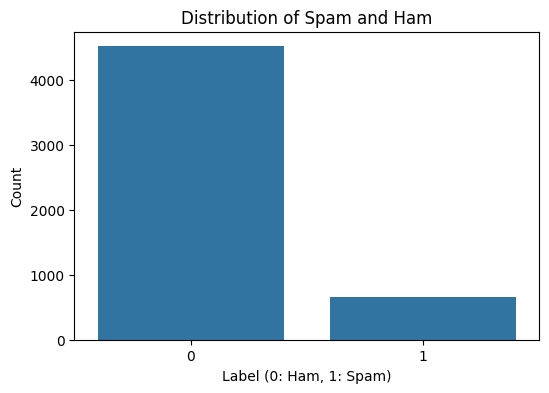

Ham: 87.37%
Spam: 12.63%


In [13]:
#데이터 불균형 시각화(비율 확인)
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df4)
plt.title('Distribution of Spam and Ham')
plt.xlabel('Label (0: Ham, 1: Spam)')
plt.ylabel('Count')
plt.show()

countHam=0
countSpam=0
countTotal=0
for i in df4['label']:
    if i==0:
        countHam+=1
    else:
        countSpam+=1
countTotal=countHam+countSpam
print("Ham: %.2f%%" % ((countHam/countTotal)*100))
print("Spam: %.2f%%" % ((countSpam/countTotal)*100))

/usr/local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When 

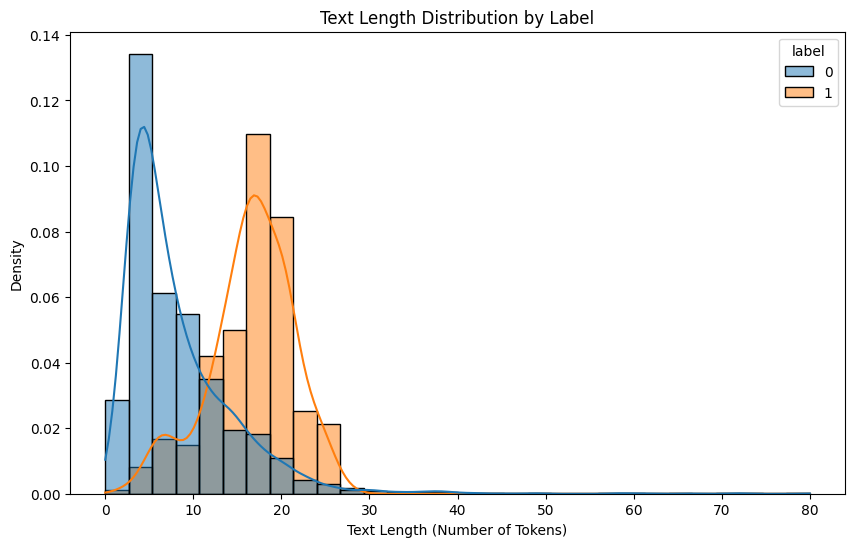

In [14]:
# 문장 길이 분석
df4['text_length'] = df4['tokens'].apply(len)
plt.figure(figsize=(10,6))
sns.histplot(data=df4, x='text_length', hue='label', bins=30, kde=True, stat="density", common_norm=False)
plt.title('Text Length Distribution by Label')
plt.xlabel('Text Length (Number of Tokens)')
plt.ylabel('Density')
plt.show()

#스팸 메일의 토큰이 비교적 많은 경향이 있음

In [15]:
%pip install -r requirements.txt --upgrade

Note: you may need to restart the kernel to use updated packages.


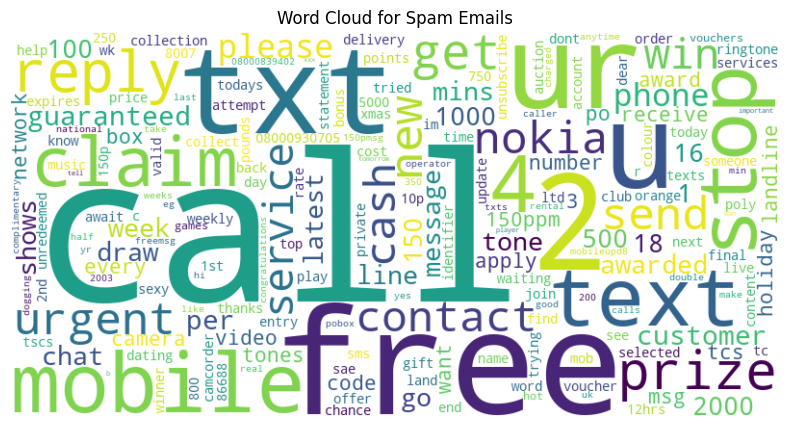

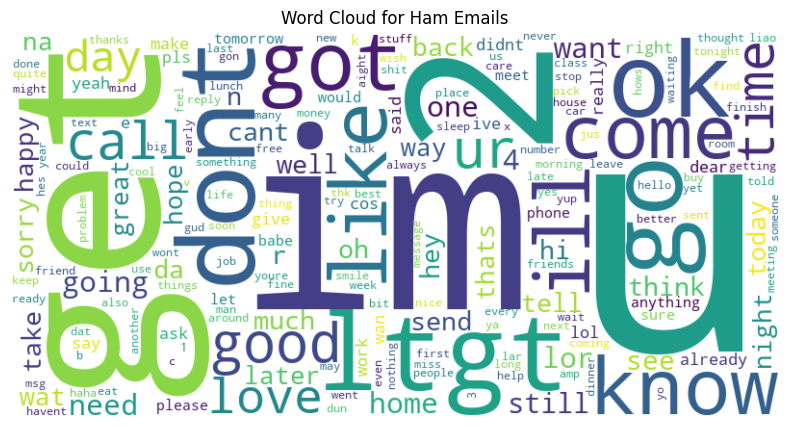

In [ ]:
# 빈출 단어 시각화
from collections import Counter
from wordcloud import WordCloud

wordFreqSpam = Counter()
wordFreqHam = Counter()

for index, row in df4.iterrows():
    if row['label'] == 1:  # 스팸 메일
        wordFreqSpam.update(row['tokens'])
    else:  # 햄 메일
        wordFreqHam.update(row['tokens'])

# 스팸 메일 단어 워드클라우드 시각화
wordcloudSpam = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordFreqSpam)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloudSpam, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Spam Emails')
plt.show()


# 비스팸 메일 단어 워드클라우드 시각화
wordcloudHam = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordFreqHam)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloudHam, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Ham Emails')
plt.show()

In [29]:
#어간 추출

porter_stemmer = PorterStemmer()

def stem_text(text) :
    return [porter_stemmer.stem(word) for word in text]

df4['stemmed_text'] = df4['tokens'].apply(stem_text)
df4.head()

,label,tokens,text_length,stemmed_text
0,0,"[go, jurong, point, crazy, available, bugis, n...",16,"[go, jurong, point, crazi, avail, bugi, n, gre..."
1,0,"[ok, lar, joking, wif, u, oni]",6,"[ok, lar, joke, wif, u, oni]"
2,1,"[free, entry, 2, wkly, comp, win, fa, cup, fin...",23,"[free, entri, 2, wkli, comp, win, fa, cup, fin..."
3,0,"[u, dun, say, early, hor, u, c, already, say]",9,"[u, dun, say, earli, hor, u, c, alreadi, say]"
4,0,"[nah, dont, think, goes, usf, lives, around, t...",8,"[nah, dont, think, goe, usf, live, around, tho..."
